<a href="https://colab.research.google.com/github/R267/indz_analys/blob/main/indz4.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><center>Незбалансована класифікація</center></h2>
<div style="font-family:verdana; word-spacing:1.5px;">
Незбалансована класифікація передбачає розробку прогнозних моделей на наборах даних класифікації, які мають серйозний дисбаланс класів. Проблема роботи з незбалансованими наборами даних полягає в тому, що більшість методів машинного навчання ігноруватимуть і, у свою чергу, матимуть низьку продуктивність на меншинному класі, хоча зазвичай найважливішою є продуктивність на меншинному класі.
</div>    

![image.png](attachment:image.png)


<p style="font-family:verdana; word-spacing:1.5px;font-size:15px">Посилання на блокнот для методів надмірної та меншої вибірки для незбалансованої класифікації:</p>
<a href='https://www.kaggle.com/ashrafkhan94/imbalanced-classification-over-under-sampling?scriptVersionId=52762319'>https://www.kaggle.com/ashrafkhan94/imbalanced-classification-over-under-sampling</a>
<br><br>
<p style="font-family:verdana; word-spacing:1.5px;font-size:15px">Посилання на блокнот для чутливих до вартості алгоритмів незбалансованої класифікації:</p>
<a href='https://www.kaggle.com/ashrafkhan94/imbalanced-classification-cost-sensitive-algrthms?scriptVersionId=52794216'>https://www.kaggle.com/ashrafkhan94/imbalanced-classification-cost-sensitive-algrthms</a>


<h3><center>1. Переміщення порогу ймовірності</center></h3>
<div style="font-family:verdana; word-spacing:1.5px;">
   Багато алгоритмів машинного навчання здатні передбачати ймовірність або оцінку членства в класі, і це потрібно інтерпретувати, перш ніж його можна буде зіставити з чіткою міткою класу. Це досягається за допомогою порогового значення, наприклад 0,5, де всі значення, що дорівнюють або перевищують порогове значення, відображаються в одному класі, а всі інші значення – в іншому класі.<br><br>
Для проблем класифікації, які мають серйозний дисбаланс класів, поріг за замовчуванням може призвести до низької продуктивності.<br><br>
    У деяких випадках, наприклад під час використання кривих ROC і кривих точного запам’ятовування, найкращий або оптимальний поріг для класифікатора можна обчислити безпосередньо. В інших випадках можна використовувати пошук по сітці, щоб налаштувати поріг і знайти оптимальне значення.<br><br>
<h4 style="font-family:verdana; word-spacing:1.5px;font-size:16px">1. Converting Probabilities to Class Labels</h4>

Рішення щодо перетворення прогнозованої ймовірності або оцінки в мітку класу регулюється параметром, який називається порогом рішення, порогом розрізнення або просто порогом. Значення за замовчуванням для порогового значення становить 0,5 для нормалізованих прогнозованих ймовірностей або балів у діапазоні від 0 до 1.<br>
<h4 style="font-family:verdana; word-spacing:1.5px;font-size:16px">2. Переміщення порогу для незбалансованої класифікації</h4>
Нам потрібно шукати діапазон порогових значень, щоб знайти найкраще порогове значення.<br> У деяких випадках оптимальне порогове значення можна обчислити безпосередньо. Налаштування або зсув порогу прийняття рішення для того, щоб задовольнити ширші вимоги проблеми класифікації, зазвичай називають переміщенням порогу, налаштуванням порогу або просто пороговим значенням.
    </div>

<div style="font-family:verdana; word-spacing:1.5px;">
<h3>1.1 Оптимальний поріг: крива ROC</h3>
    Коефіцієнт хибнопозитивного результату відкладається на осі абсцис, а коефіцієнт справжнього позитивного результату – на осі у, і цей графік називається кривою робочих характеристик приймача або кривою ROC. <br>Діагональна лінія на графіку від нижнього лівого до верхнього правого кута вказує на криву для класифікатора без навичок (прогнозує клас більшості в усіх випадках), а точка у верхньому лівому куті графіка вказує на модель з ідеальними навичками.<br><br>
    Є багато способів, якими ми можемо визначити порогове значення з оптимальним балансом між хибно-позитивними та справжніми позитивними показниками. По-перше, справжній позитивний показник називається чутливістю. Один мінус хибнопозитивної частоти називається специфічністю. Середнє геометричне або G-середнє – це метрика для незбалансованої класифікації, яка, якщо її оптимізувати, шукатиме баланс між чутливістю та специфічністю.
    </div>
    
![image.png](attachment:image.png)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, f1_score
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

0it [00:00, ?it/s]

In [2]:
def run_model():
    X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
        n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2,
        stratify=y)
    model = LogisticRegression(solver='lbfgs')
    model.fit(trainX, trainy)

    yhat = model.predict_proba(testX)

    # Positive class values
    yhat = yhat[:, 1]

    return yhat, testy

In [3]:
yhat, testy = run_model()

fpr, tpr, thresholds = roc_curve(testy, yhat)
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.015790, G-mean=0.934


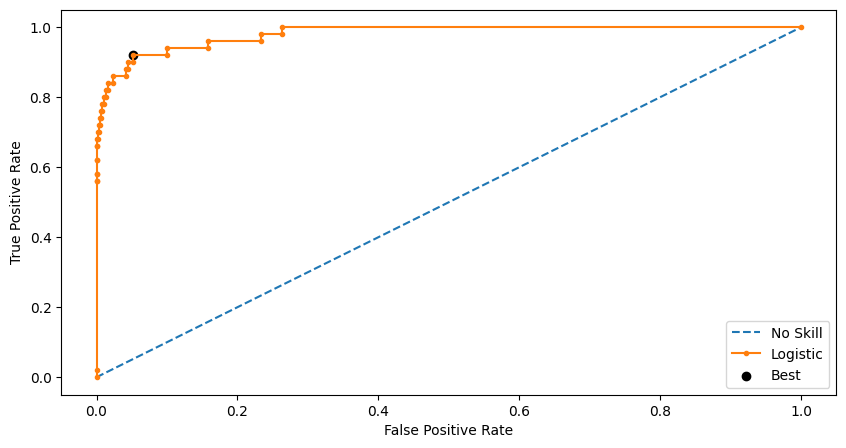

In [4]:
plt.figure(figsize=(10,5))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

<div style="font-family:verdana; word-spacing:1.5px;">
<h3>1.2 Оптимальний поріг: крива точного запам'ятовування</h3>

На відміну від кривої ROC, крива точності запам’ятовування зосереджена на продуктивності класифікатора лише для позитивного (міноритарного класу). Точність – це відношення кількості справжніх позитивних результатів, поділених на суму справжніх позитивних і хибних позитивних результатів. <br><br>Він описує, наскільки добре модель прогнозує позитивний клас. Відкликання розраховується як відношення кількості істинно позитивних результатів, поділених на суму істинно позитивних і хибно негативних результатів.</div>

In [5]:
yhat, testy = run_model()

precision, recall, thresholds = precision_recall_curve(testy, yhat)

#Calculate f-Score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest g-mean
ix = np.argmax(fscore)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.257034, G-mean=0.756


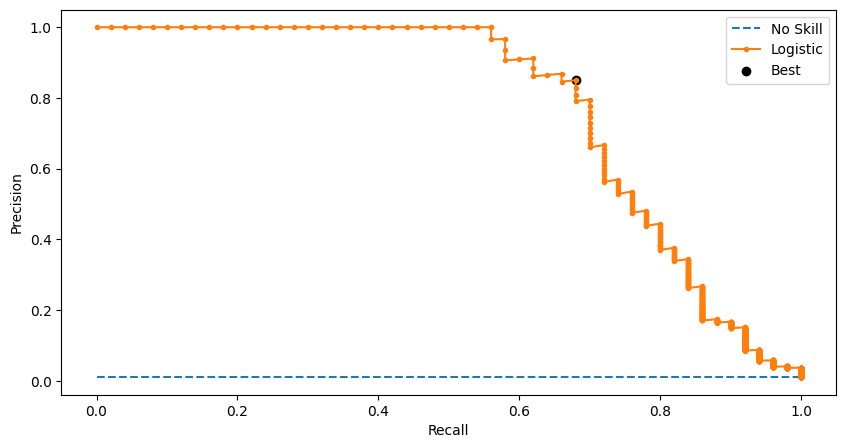

In [6]:
no_skill = len(testy[testy==1]) / len(testy)

plt.figure(figsize=(10,5))
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

<div style="font-family:verdana; word-spacing:1.5px;">
<h3>1.3 Оптимальне налаштування порогу</h3>
    Іноді ми просто маємо модель і хочемо безпосередньо знати найкращий поріг.<br> У цьому випадку ми можемо визначити набір порогів, а потім оцінити прогнозовані ймовірності для кожного, щоб знайти та вибрати оптимальний поріг. </div>

In [7]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat, ytest = run_model()

thresholds = np.arange(0, 1, 0.001)

scores = [f1_score(ytest,to_labels(yhat, t)) for t in thresholds]

ix = np.argmax(scores)
print('Threshold=%.3f, F-measure=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.252, F-measure=0.75556


<h3><center>2. Калібрування ймовірності</center></h3>
<div style="font-family:verdana; word-spacing:1.5px;">
Відкалібровані ймовірності означають, що ймовірність відображає ймовірність справжніх подій. Це може ввести в оману, якщо ви вважаєте, що в класифікації ми маємо мітки класів, які є правильними чи ні, замість ймовірностей.<br><br>
    Якщо передбачити 100 прикладів з імовірністю 0,8, то 80 відсотків прикладів матимуть клас 1, а 20 відсотків матимуть клас 0, якщо ймовірності відкалібровано.<br><br>
Імовірності калібруються шляхом перемасштабування їхніх значень, щоб вони краще відповідали розподілу, що спостерігається в даних навчання.<br>
    Прогнози ймовірностей створюються на основі навчальних даних, а розподіл ймовірностей порівнюється з очікуваними ймовірностями та коригується для забезпечення кращої відповідності.<br><br>
<ul>    Існує дві основні методики масштабування прогнозованих ймовірностей; це шкала Платта та ізотонічна регресія.
    <li>Масштабування Платта. Модель логістичної регресії для перетворення ймовірностей.
    <li>Ізотонічна регресія. Зважена регресійна модель найменших квадратів для перетворення ймовірностей.
    </ul>
   Бібліотека scikit-learn надає доступ як до методів масштабування Платта, так і до методів ізотонічної регресії для калібрування ймовірностей через клас CalibratedClassifierCV. Це оболонка для моделі (наприклад, SVM). Бажана техніка масштабування визначається за допомогою аргументу методу, який може бути «сигмоїдним» (шкалювання Платта) або «ізотонічним» (ізотонічна регресія).
    </div>

<h3>2.1. SVM із каліброваною ймовірністю</h3>

<h4> Перед калібруванням </h4>

In [8]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)


model = SVC(gamma='scale')


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.808


<h4>Після калібрування</h4>

In [9]:
from sklearn.calibration import CalibratedClassifierCV

model = SVC(gamma='scale')

calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


scores = cross_val_score(calibrated, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.867


<h4>Калібрування + вагові коефіцієнти класів (евристика - зворотний розподіл)</h4>

In [10]:
from sklearn.calibration import CalibratedClassifierCV

model = SVC(gamma='scale', class_weight='balanced')

calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


scores = cross_val_score(calibrated, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.964


<h3>2.2. Калібрування ймовірності пошуку сітки за допомогою KNN

In [11]:
model = KNeighborsClassifier()

calibrated = CalibratedClassifierCV(model)

param_grid = dict(cv=[2,3,4], method=['sigmoid','isotonic'])


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = GridSearchCV(estimator=calibrated, param_grid=param_grid, n_jobs=-1, cv=cv,
scoring='roc_auc')

grid_result = grid.fit(X, y)


print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_)) # report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.895029 using {'cv': 2, 'method': 'sigmoid'}
0.895029 (0.066617) with: {'cv': 2, 'method': 'sigmoid'}
0.893549 (0.065846) with: {'cv': 2, 'method': 'isotonic'}
0.886835 (0.070207) with: {'cv': 3, 'method': 'sigmoid'}
0.885104 (0.071671) with: {'cv': 3, 'method': 'isotonic'}
0.885167 (0.071732) with: {'cv': 4, 'method': 'sigmoid'}
0.877146 (0.077137) with: {'cv': 4, 'method': 'isotonic'}


<h3><center>3. Алгоритми ансамблю</center></h3>
<h3>3.1. Пакування в мішки з випадковою недостатньою вибіркою</h3>
<div style="font-family:verdana; word-spacing:1.5px;">
Перевибірка класу меншості в системі початкового завантаження називається OverBagging; так само, недобірка більшості класів у завантажувальній системі називається UnderBagging, а поєднання обох підходів називається OverUnderBagging. <br><br>Бібліотека незбалансованого навчання забезпечує реалізацію UnderBagging. Зокрема, він надає версію пакетування, яка використовує стратегію випадкової недостатньої вибірки для більшості класів у початковій вибірці, щоб збалансувати два класи. Це надається в класі BalancedBaggingClassifier.</div>

In [12]:
from imblearn.ensemble import BalancedBaggingClassifier

model = BalancedBaggingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.965


<h3>3.2. Випадковий ліс із зважуванням класу</h3>

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=20, class_weight='balanced')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.887


<h3>3.3. Випадковий ліс із зважуванням класу Bootstrap </h3>
<div style="font-family:verdana; word-spacing:1.5px;">
Враховуючи те, що кожне дерево рішень побудовано із вибірки початкового завантаження (наприклад, випадковий вибір із заміною), розподіл класів у вибірці даних буде різним для кожного дерева. Таким чином, може бути цікаво змінити зважування класу на основі розподілу класів у кожному початковому зразку замість усього навчального набору даних. Цього можна досягти, встановивши аргумент ваги класу на значення «збалансована підвибірка».</div>

In [14]:
model = RandomForestClassifier(n_estimators=20, class_weight='balanced_subsample')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.888


<h3>3.4. Випадковий ліс із випадковою недостатньою вибіркою</h3>


In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(n_estimators=20)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.968


<h3>3.5. Легкий ансамбль</h3>

<div style="font-family:verdana; word-spacing:1.5px;">
Easy Ensemble передбачає створення збалансованих зразків навчального набору даних шляхом вибору всіх прикладів із класу меншості та підмножини з класу більшості. Замість використання скорочених дерев рішень для кожної підмножини використовуються розширені дерева рішень, зокрема алгоритм AdaBoost.<br><br>
   AdaBoost працює так, що спочатку підбирає дерево рішень для набору даних, потім визначає помилки, зроблені деревом, і зважує приклади в наборі даних за цими помилками, щоб більше уваги приділялося неправильно класифікованим прикладам і менше – правильно класифікованим. Потім наступне дерево підганяється до зваженого набору даних, щоб виправити помилки. Потім процес повторюється для заданої кількості дерев рішень.
    </div>

In [16]:
from imblearn.ensemble import EasyEnsembleClassifier

model = EasyEnsembleClassifier(n_estimators=20)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.965


<h3><center>4. Однокласова класифікація</center></h3>

<div style="font-family:verdana; word-spacing:1.5px;">
Виявлення викидів у даних називається виявленням викидів або аномалій, а підсфера машинного навчання, зосереджена на цій проблемі, називається однокласовою класифікацією.<br><br> Це алгоритми неконтрольованого навчання, які намагаються моделювати звичайні приклади, щоб класифікувати нові приклади як нормальні чи ненормальні (наприклад, викиди). Однокласові алгоритми класифікації можна використовувати для завдань бінарної класифікації з сильно викривленим розподілом класів.</div><br><br>

![image.png](attachment:image.png)

<h3>4.1. Однокласові опорні векторні машини </h3>

![image.png](attachment:image.png)

<div style="font-family:verdana; word-spacing:1.5px;">
гіперпараметр nu контролює чутливість опорних векторів і повинен бути налаштований на приблизне співвідношення викидів у даних, напр. 0,01%.<br><br>
Після підгонки модель можна використовувати для виявлення викидів у нових даних. Під час виклику функції predict() для моделі вона виведе +1 для звичайних прикладів, так званих інлієрів, і -1 для викидів.
<br><br>
    Якщо ми хочемо оцінити продуктивність моделі як бінарного класифікатора, ми повинні змінити мітки в тестовому наборі даних з 0 і 1 для більшості і меншості класів відповідно на
+1 і -1.
    <br><br><br>
    Оскільки ми не навчаємо calss меншості (label=1) для викидів, ми позначатимемо їх як -1 (викиди) у перевірених даних.<br>
    Оскільки ми навчаємо лише мажоритарний клас, коли ми прогнозуємо модель за допомогою даних testX (які містять як більшість, так і меншість), модель призначатиме -1 для меншості (оскільки вона не була навчена), 1 для внутрішніх даних класу mojaority та -1 для вихідних даних для більшості.
<br><br><br>
Ми можемо обчислити F-міру за допомогою функції f1 score() і вказати мітку класу меншості як -1 через аргумент pos label.
</div>


In [17]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.999], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2,
    stratify=y)

In [18]:
from sklearn.svm import OneClassSVM

model = OneClassSVM(gamma='scale', nu=0.01)

trainX = trainX[trainy ==0]

model.fit(trainX)

yhat = model.predict(testX)

# Marking minority class data as outlier(-1) and majority as inlier(1).

testy[testy == 1] = -1
testy[testy == 0] = 1

score = f1_score(testy, yhat, pos_label=-1)
print('F-measure: %.3f' % score)

F-measure: 0.123


<h3>4.2. Ізоляція Форрест </h3>

In [21]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import pandas as pd

# Узгодження розміру
min_len = min(len(trainX), len(trainy))
trainX_trimmed = trainX[:min_len]
trainy_trimmed = trainy[:min_len]

# Об'єднання у DataFrame
train_df = pd.DataFrame(trainX_trimmed)
train_df['target'] = trainy_trimmed

# Відбір лише нормальних (неаномальних) зразків
train_df = train_df[train_df['target'] == 0]

# Підготовка до навчання
trainX_filtered = train_df.drop('target', axis=1).values

# Навчання моделі Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(trainX_filtered)

# Передбачення
yhat = model.predict(testX)

# Адаптація testy під формат аномалій
testy_adj = testy.copy()
testy_adj[testy == 1] = -1
testy_adj[testy == 0] = 1

# Оцінка F1
score = f1_score(testy_adj, yhat, pos_label=-1)
print('F-measure: %.3f' % score)



F-measure: 0.013


забруднення є досить низьким і може призвести до багатьох прогонів із F-мірою 0,0. Щоб підвищити стабільність методу на цьому наборі даних, спробуйте збільшити забруднення до 0,05 або навіть 0,1 і повторно запустіть приклад.

In [24]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import numpy as np

# Синхронізація розмірів
min_len = min(len(trainX), len(trainy))
trainX = trainX[:min_len]
trainy = trainy[:min_len]

# Вибір нормальних зразків (0)
normal_trainX = trainX[trainy == 0]

# Створення та тренування моделі
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(normal_trainX)

# Прогноз
yhat = model.predict(testX)

# Перетворення міток: 1 → -1 (аномалія), 0 → 1 (нормальні)
testy_converted = np.copy(testy)
testy_converted[testy_converted == 1] = -1
testy_converted[testy_converted == 0] = 1

# Обчислення F1-метрики
score = f1_score(testy_converted, yhat, pos_label=-1)
print('F-measure: %.3f' % score)



F-measure: 0.181


<h3>4.3. Детермінант мінімальної коваріації</h3>


Якщо вхідні змінні мають розподіл Гауса, то для виявлення викидів можна використовувати прості статистичні методи. Наприклад, якщо набір даних має дві вхідні змінні, і обидві є Гаусовими, тоді простір ознак утворює багатовимірний Гаусів і знання цього розподілу можна використовувати для визначення значень, далеких від розподілу.

In [25]:
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=0.1)

trainX = trainX[trainy ==0]

model.fit(trainX)

yhat = model.predict(testX)

# Marking minority class data as outlier(-1) and majority as inlier(1).

testy[testy == 1] = -1
testy[testy == 0] = 1

score = f1_score(testy, yhat, pos_label=-1)
print('F-measure: %.3f' % score)

F-measure: 0.179
